# Generation of Figure for "A Sample Path Measure of Causal Influence"

*Gabe Schamberg and Todd Coleman*

## Signal Model

Define the following probabilities:

$$
P(X_n = 1 \mid X^{n-1} = x^{n-1}, Y^{n-1} = y^{n-1}) = P(X_n = 1 \mid X_{n-1} = x_{n-1}, Y_{n-1} = y_{n-1}) = \frac{\exp(\theta_0 + \theta_1 x_{n-1} + \theta_2 y_{n-1})}{1+\exp(\theta_0 + \theta_1 x_{n-1} + \theta_2 y_{n-1})}
$$

$$
P(Y_n = 1 \mid Y^{n-1} = y^{n-1}, X^{n-1} = x^{n-1}) = P(Y_n = 1 \mid Y_{n-1} = y_{n-1}, X_{n-1} = x_{n-1}) = \frac{\exp(\gamma_0 + \gamma_1 y_{n-1} + \gamma_2 x_{n-1})}{1+\exp(\gamma_0 + \gamma_1 y_{n-1} + \gamma_2 x_{n-1})}
$$

with $Y_0 = X_0 = 0$ used to ensure the probabilities for $X_1$ and $Y_1$ are well defined.

## Sequential Prediction
Once a signal is generated, we want to sequentially estimate four probabilities:

\begin{align}
\hat{P}_{X_n}^{(c)} &\triangleq \hat{P}(X_n = 1 \mid X^{n-1} = x^{n-1}, Y^{n-1} = y^{n-1}) \\
\hat{P}_{X_n}^{(r)} &\triangleq \hat{P}(X_n = 1 \mid X^{n-1} = x^{n-1}) \\
\hat{P}_{Y_n}^{(c)} &\triangleq \hat{P}(Y_n = 1 \mid Y^{n-1} = y^{n-1}, X^{n-1} = x^{n-1}) \\
\hat{P}_{Y_n}^{(r)} &\triangleq \hat{P}(Y_n = 1 \mid Y^{n-1} = y^{n-1}) \\
\end{align}

Here we'll estimate using a Bayesian updating scheme - ***description to come...***

## Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Generate Sequences

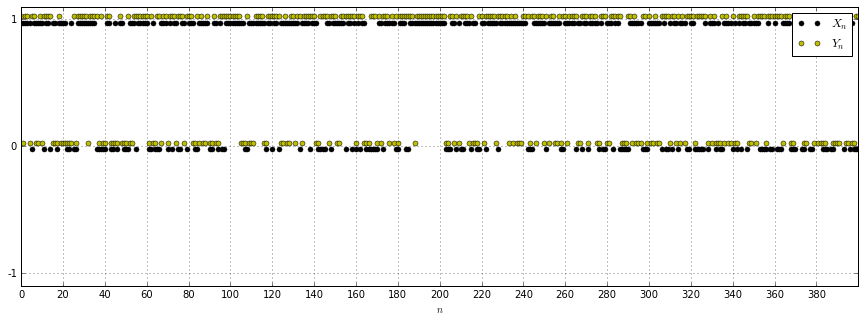

In [2]:
# Ns - List of integers with number of samples for each parameter regime
# thetas - List of 3 tuples with the thetas for each parameter regime
# gammas - List of 3 tuples with the gammas for each parameter regime
def gen_sequence(Ns=[100],thetas=[(0,0,0)],gammas=[(0,0,0)],plot = True):
    if len(Ns) != len(thetas) or len(Ns) != len(gammas):
        print("Usage: Ns=[numsamples1,...,numsamplesN],thetas=[(t11,t12,t13),...,(tN1,tN2,tN3)],gammas=[(g11,g12,g13),...,(gN1,gN2,gN3)]")
        raise ValueError
    
    # Start in first regime
    theta = thetas[0]
    gamma = gammas[0]
    X = []
    Y = []
    X.append((np.random.binomial(1,0.5,1))) 
    Y.append((np.random.binomial(1,0.5,1))) 
    px = []
    py = []
    px.append(theta[0])
    py.append(gamma[0])
    
    offset = 0
    # loop through regimes
    for i,N in enumerate(Ns):
        # set parameters
        t0 = thetas[i][0]
        t1 = thetas[i][1]
        t2 = thetas[i][2]
        g0 = gammas[i][0]
        g1 = gammas[i][1]
        g2 = gammas[i][2]
        # generate each sample in current regime
        for n in range(N):
            # get previous samples
            x_prev = X[offset + n]
            y_prev = Y[offset + n]
            # compute probabilities
            x_p = np.exp(t0 + t1*x_prev + t2*y_prev) / (1 + np.exp(t0 + t1*x_prev + t2*y_prev))
            y_p = np.exp(g0 + g1*y_prev + g2*x_prev) / (1 + np.exp(g0 + g1*y_prev + g2*x_prev))
            # generate new samples
            X.append((np.random.binomial(1,x_p,1)))
            Y.append((np.random.binomial(1,y_p,1)))
            px.append(x_p)
            py.append(y_p)
        offset += N
    
    if not plot:
        return X, Y, px, py
    else:
        fig,ax = plt.subplots(figsize = (15,5))
        ax.plot([x-0.025 for x in X],'ko',label='$X_n$',markersize=5)
        ax.plot([y+0.025 for y in Y],'yo',label='$Y_n$',markersize=5)
        ax.xaxis.set(ticks=np.arange(0,sum(Ns),sum(Ns)//20))
        ax.yaxis.set(ticks=(-1,0,1), ticklabels=('-1','0','1'))
        ax.set_ylim([-1.1,1.1])
        ax.grid('on')
        ax.set_xlabel('$n$')
        ax.legend()
        return X, Y, px, py, ax
        
gen_sequence(Ns=[300,100],thetas=[(0,0.5,0.5),(0,0,0)],gammas=[(0.5,0,0),(0.5,0,0)]);

### Estimators

#### (1) Bayesian Mixture of Expert Advice

In [3]:
from itertools import product

class BMEAEstimator:
    
    def __init__(self,X,Y,param_min=-5,param_max=5,num_params=10,lam=1):
        self.label = "BMEA"
        
        # The two point processes
        self.X = X
        self.Y = Y
        
        # Number of experts for the conditional and marginal models
        self.K_cond = num_params**3
        self.K_marg = num_params**2
        
        # Weight for each predictor starts uniform
        self.wxy = np.ones(self.K_cond)*(1/self.K_cond)
        self.wyx = np.ones(self.K_cond)*(1/self.K_cond)
        self.wx = np.ones(self.K_marg)*(1/self.K_marg)
        self.wy = np.ones(self.K_marg)*(1/self.K_marg)
        
        self.w0_cond = self.wxy
        self.w0_marg = self.wx
        
        # Stationarity weight (1 -> sationarity)
        self.lam = lam
        
        # Create experts for each model
        E = np.linspace(param_min,param_max,num_params)
        self.E_cond = np.zeros((3,num_params**3))
        for i,expert in enumerate(product(E,E,E)):
            self.E_cond[:,i] = np.asarray(expert)
        self.E_marg = np.zeros((2,num_params**2))
        for i,expert in enumerate(product(E,E)):
            self.E_marg[:,i] = np.asarray(expert)
      
    # Evaluate likelihood for conditional model (q/z/params are x/y/theta or y/x/gamma)
    def p_cond(self,qn,qprev,zprev,params):
        p0 = params[0]
        p1 = params[1]
        p2 = params[2]
        qn_1_prob = np.exp(p0 + p1*qprev + p2*zprev) / (1 + np.exp(p0 + p1*qprev + p2*zprev))
        if qn == 1:
            return qn_1_prob
        else:
            return 1 - qn_1_prob
        
    # Evaluate likelihood for marginal model
    def p_marg(self,qn,qprev,params):
        p0 = params[0]
        p1 = params[1]
        qn_1_prob = np.exp(p0 + p1*qprev) / (1 + np.exp(p0 + p1*qprev))
        if qn == 1:
            return qn_1_prob
        else:
            return 1 - qn_1_prob
        
    def kl(self,p1,p2):
        return p1*np.log(p1/p2) + (1-p1)*np.log((1-p1)/(1-p2))
    
    def predict(self):
        # Keep running estimates of params
        est_theta_cond = []
        est_theta_marg = []
        est_gamma_cond = []
        est_gamma_marg = []
        # Keep running estimates of directed info
        C_xy = []
        C_yx = []
        # Keep running estimates of distributions
        xy_dist = [0.5]
        yx_dist = [0.5]
        x_dist = [0.5]
        y_dist = [0.5]
        
        for n in range(1,len(self.X)):
            xn = self.X[n]
            yn = self.Y[n]
            xprev = self.X[n-1]
            yprev = self.Y[n-1]
            
            # Current parameter estimates are weighted avgs of experts
            est_theta_cond.append(np.dot(self.E_cond,self.wxy))
            est_gamma_cond.append(np.dot(self.E_cond,self.wyx))
            est_theta_marg.append(np.dot(self.E_marg,self.wx))
            est_gamma_marg.append(np.dot(self.E_marg,self.wy))
            
            # Get KLs with new parameter estimates
            theta_cond_p = self.p_cond(1,xprev,yprev,est_theta_cond[-1])
            theta_marg_p = self.p_marg(1,xprev,est_theta_marg[-1])
            C_yx.append(self.kl(theta_cond_p,theta_marg_p))
            gamma_cond_p = self.p_cond(1,yprev,xprev,est_gamma_cond[-1])
            gamma_marg_p = self.p_marg(1,yprev,est_gamma_marg[-1])
            C_xy.append(self.kl(gamma_cond_p,gamma_marg_p))
            
            # Track distributions
            xy_dist.append(theta_cond_p)
            yx_dist.append(gamma_cond_p)
            x_dist.append(theta_marg_p)
            y_dist.append(gamma_marg_p)
            
            # Evaluate likelihoods
            pxy = np.asarray([self.p_cond(xn,xprev,yprev,self.E_cond[:,i]) for i in range(self.K_cond)]).reshape((self.K_cond))
            pyx = np.asarray([self.p_cond(yn,yprev,xprev,self.E_cond[:,i]) for i in range(self.K_cond)]).reshape((self.K_cond))
            px = np.asarray([self.p_marg(xn,xprev,self.E_marg[:,i]) for i in range(self.K_marg)]).reshape((self.K_marg))
            py = np.asarray([self.p_marg(yn,yprev,self.E_marg[:,i]) for i in range(self.K_marg)]).reshape((self.K_marg))
            
            # Update weights
            self.wxy = self.lam*np.multiply(pxy,self.wxy)/np.dot(pxy.T,self.wxy) + (1-self.lam)*self.w0_cond
            self.wyx = self.lam*np.multiply(pyx,self.wyx)/np.dot(pyx.T,self.wyx) + (1-self.lam)*self.w0_cond
            self.wx = self.lam*np.multiply(px,self.wx)/np.dot(px.T,self.wx) + (1-self.lam)*self.w0_marg
            self.wy = self.lam*np.multiply(py,self.wy)/np.dot(py.T,self.wy) + (1-self.lam)*self.w0_marg
            
        return C_xy, C_yx, est_theta_cond, est_gamma_cond, est_theta_marg, est_gamma_marg, xy_dist, yx_dist, x_dist, y_dist

## Computing True Causal Measure

In [4]:
def compute_causality(X,Y,thetas,gammas,Ns,plot=True,ax=None):
    # The complete model probability of 1
    p_x_c = 0
    P_y_c = 0
    # The restricted model probability of 1
    p_x_r = 0
    p_y_r = 0
    # Auxiliary params for updating restricted model (prob of current x given past of y)
    p_x_y = 0    
    p_y_x = 0
    # Causal measures
    x2y = []
    y2x = []
    # Track where we are in the sequences
    offset = 0
    for regime,N in enumerate(Ns):
        [theta0,theta1,theta2] = thetas[regime]
        [gamma0,gamma1,gamma2] = gammas[regime]
        for n in range(offset, offset + N):
            # Update the complete model
            p_x_c = np.exp(theta0 + theta1*X[n] + theta2*Y[n])/(1 + np.exp(theta0 + theta1*X[n] + theta2*Y[n]))
            p_y_c = np.exp(gamma0 + gamma1*Y[n] + gamma2*X[n])/(1 + np.exp(gamma0 + gamma1*Y[n] + gamma2*X[n]))
            # Update the restricted model
            p_x_r = p_y_x * (np.exp(theta0 + theta1*X[n] + theta2)/(1 + np.exp(theta0 + theta1*X[n] + theta2))) + \
                (1-p_y_x) * (np.exp(theta0 + theta1*X[n] - theta2)/(1 + np.exp(theta0 + theta1*X[n] - theta2)))
            p_y_r = p_x_y * (np.exp(gamma0 + gamma1*Y[n] + gamma2)/(1 + np.exp(gamma0 + gamma1*Y[n] + gamma2))) + \
                (1-p_x_y) * (np.exp(gamma0 + gamma1*Y[n] - gamma2)/(1 + np.exp(gamma0 + gamma1*Y[n] - gamma2)))
            # Update the auxiliary params
            p_y_x = p_y_x * (np.exp(gamma0 + gamma1 + gamma2*X[n])/(1 + np.exp(gamma0 + gamma1 + gamma2*X[n]))) + \
                (1-p_y_x) * (np.exp(gamma0 - gamma1 + gamma2*X[n])/(1 + np.exp(gamma0 - gamma1 + gamma2*X[n])))
            p_x_y = p_x_y * (np.exp(theta0 + theta1 + theta2*Y[n])/(1 + np.exp(theta0 + theta1 + theta2*Y[n]))) + \
                (1-p_x_y) * (np.exp(theta0 - theta1 + theta2*Y[n])/(1 + np.exp(theta0 - theta1 + theta2*Y[n])))
            # Update causal measures
            x2y.append(p_y_c*np.log(p_y_c/p_y_r) + (1-p_y_c)*np.log((1-p_y_c)/(1-p_y_r)))
            y2x.append(p_x_c*np.log(p_x_c/p_x_r) + (1-p_x_c)*np.log((1-p_x_c)/(1-p_x_r)))
        offset += N
    if not plot:
        return x2y, y2x
    else:
        if ax is None:
            fig,ax = plt.subplots(figsize = (15,5))
        ax.plot(x2y,color='m',label='$C_{X -> Y}(n)$')
        ax.plot(y2x,color='y',label='$C_{Y -> X}(n)$')
        ax.grid('on')
        ax.set_xlabel('$n$')
        ax.xaxis.set(ticks=np.arange(0,sum(Ns),sum(Ns)//20))
        ax.legend()
        return x2y, y2x, ax

### Results

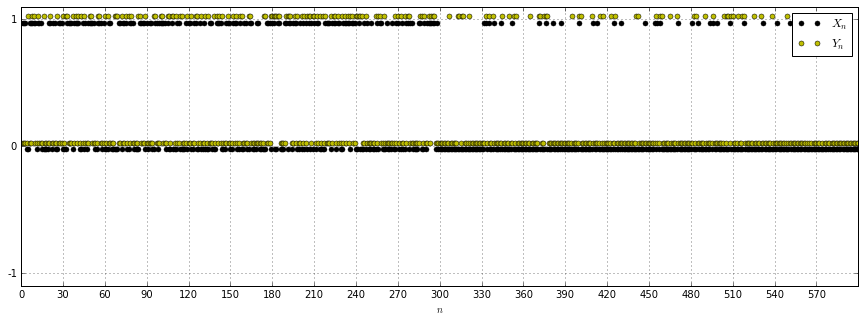

In [11]:
# Set the parameters
Ns=[300,300]
thetas=[(0.0,0,0.7),(-2,0,0.2)]
gammas=[(-0.5,0.0,0),(-2,0.0,1.5)]

# Generate a pair of sequences
X, Y, true_px, true_py, ax = gen_sequence(Ns=Ns, thetas=thetas,gammas=gammas)

# Estimate the causality
estimator = BMEAEstimator(X,Y,num_params=10,lam=0.9999,param_max=2,param_min=-2)
C_xy_hat, C_yx_hat, est_theta_cond, est_gamma_cond, est_theta_marg, est_gamma_marg, pxy, pyx, px, py = estimator.predict()

# Compute true causal effect
C_xy, C_yx = compute_causality(X,Y,thetas,gammas,Ns,plot=False)

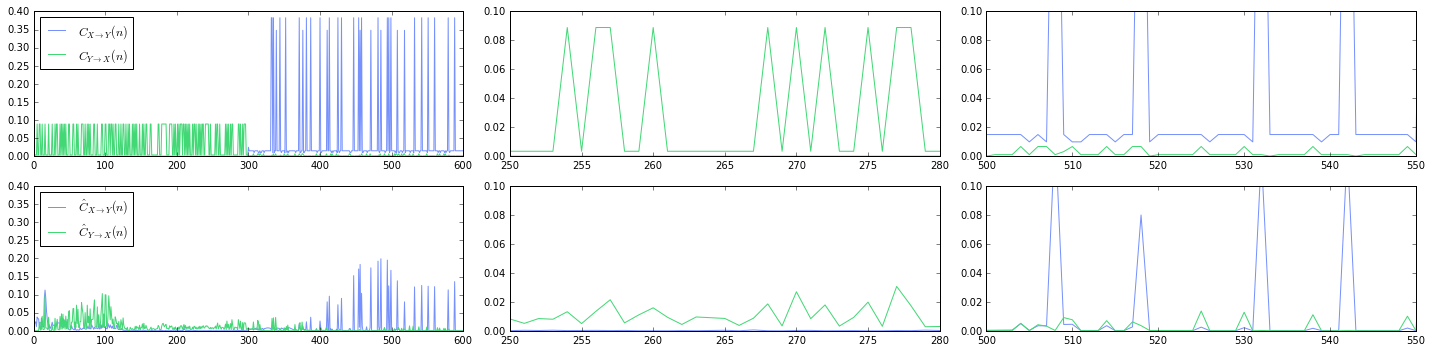

In [24]:
fig, [[true,twin1,twin2],[est,ewin1,ewin2]] = plt.subplots(2,3,figsize=(20,5))

true.plot(C_xy,label=r'$C_{X \rightarrow Y}(n)$',c='#7691fc')
true.plot(C_yx,label=r'$C_{Y \rightarrow X}(n)$',c='#41d875')    
true.legend(loc='upper left')
true.set_ylim([0,0.4])

twin1.plot(C_xy,c='#7691fc')
twin1.plot(C_yx,c='#41d875')    
twin1.set_ylim([0,0.1])
twin1.set_xlim([250,280])

twin2.plot(C_xy,c='#7691fc')
twin2.plot(C_yx,c='#41d875')    
twin2.set_ylim([0,0.1])
twin2.set_xlim([500,550])

est.plot(C_xy_hat,label=r'$\hat{C}_{X \rightarrow Y}(n)$',c='#7691fc')
est.plot(C_yx_hat,label=r'$\hat{C}_{Y \rightarrow X}(n)$',c='#41d875')    
est.legend(loc='upper left')
est.set_ylim([0,0.4])

ewin1.plot(C_xy_hat,c='#7691fc')
ewin1.plot(C_yx_hat,c='#41d875')    
ewin1.set_ylim([0,0.1])
ewin1.set_xlim([250,280])

ewin2.plot(C_xy_hat,c='#7691fc')
ewin2.plot(C_yx_hat,c='#41d875')    
ewin2.set_ylim([0,0.1])
ewin2.set_xlim([500,550])

fig.tight_layout()
#plt.savefig('results.png',dpi=500);